In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

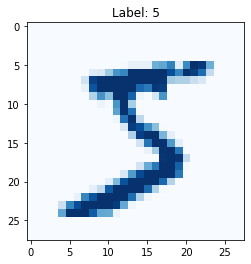

In [4]:
import matplotlib.pyplot as plt
first_image = x_train[0]
plt.imshow(first_image, cmap='Blues')
plt.title(f'Label: {y_train[0]}')
plt.show()

In [5]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [6]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
print(x_train[0])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

In [8]:
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [9]:
print(x_train.shape)

(60000, 28, 28, 1)


In [10]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [11]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

## 模型搭建

In [12]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D


class MyModel(Model):
    def __init__(self,kernel_number,kernel_size,D1_size,D2_size):
        super(MyModel, self).__init__()
        self.input_layer = tf.keras.layers.Input(shape=(18,18,1),name="input_l")
        self.conv1 = Conv2D(kernel_number, kernel_size, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(D1_size, activation='relu')
        self.d2 = Dense(D2_size)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

    def get_config(self):  
        config = {
            "kernel_number": self.kernel_number,
            "kernel_size": self.kernel_size,
            "D1_size": self.D1_size,
            "D2_size": self.D2_size
        }
        base_config = super(MyModel, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Create an instance of the model
model = MyModel(32,3,128,10)


In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [14]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [15]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True) # dropout层存在时设置为True,else False
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss) # 其显示作用，主要时跟踪loss的平均值
    train_accuracy(labels, predictions)

In [16]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False) # dropout层存在时设置为True,else False
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [17]:
import time
EPOCHS = 10

for epoch in range(EPOCHS):
  # 梯度清空
    start_time = time.time()  # 开始计时
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)


    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    end_time = time.time()  # 结束计时
    epoch_time = end_time - start_time
    
    print(
    f'Epoch {epoch + 1}, '
    f'Time: {epoch_time:.2f} sec, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
    )


Epoch 1, Time: 25.74 sec, Loss: 0.13960197567939758, Accuracy: 95.8933334350586, Test Loss: 0.056066036224365234, Test Accuracy: 98.23999786376953
Epoch 2, Time: 25.02 sec, Loss: 0.0415259450674057, Accuracy: 98.69499969482422, Test Loss: 0.051432039588689804, Test Accuracy: 98.37999725341797
Epoch 3, Time: 27.59 sec, Loss: 0.02032860927283764, Accuracy: 99.36500549316406, Test Loss: 0.06192609667778015, Test Accuracy: 98.2699966430664
Epoch 4, Time: 27.31 sec, Loss: 0.01316783670336008, Accuracy: 99.55000305175781, Test Loss: 0.06380966305732727, Test Accuracy: 98.27999877929688
Epoch 5, Time: 26.23 sec, Loss: 0.008673087693750858, Accuracy: 99.7300033569336, Test Loss: 0.07679145038127899, Test Accuracy: 97.95999908447266
Epoch 6, Time: 25.00 sec, Loss: 0.00748553266748786, Accuracy: 99.74666595458984, Test Loss: 0.06446573883295059, Test Accuracy: 98.47999572753906
Epoch 7, Time: 25.63 sec, Loss: 0.0043510738760232925, Accuracy: 99.84833526611328, Test Loss: 0.07793684303760529, Tes

In [18]:
model.save_weights("./checkpoints/my_checkpoints")

In [19]:
load_model = MyModel(32,3,128,10)
load_model.load_weights("./checkpoints/my_checkpoints")

In [20]:
load_model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy']
)
loss,acc = load_model.evaluate(test_ds)

313/313 [==============================] - 1s 3ms/step - loss: 0.0898 - accuracy: 0.9839


In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [22]:
from PIL import Image
def img_box(img):
    index=np.where(img)
    weight=img[index]
    index_x_mean=np.average(index[1],weights=weight)
    index_y_mean=np.average(index[0],weights=weight)
    index_xy_std=np.sqrt(np.average(((index[1]-index_x_mean)**2+(index[0]-index_y_mean)**2)/2,
                    weights=weight))
    box=(index_x_mean-3*index_xy_std,index_y_mean-3*index_xy_std,index_x_mean+3*index_xy_std,
            index_y_mean+3*index_xy_std)
    return box


def normalize_figure(img_path):
    image0=Image.open(img_path).convert('L')
    
    img=np.array(image0)
    # print(img)
    img=np.where(img==255,0,255)
    image=Image.fromarray(img)
    box=img_box(img)
    crop_img=image.crop(box)
    norm_img=crop_img.resize((28,28))
    # plt.imshow(norm_img,cmap='Greys',interpolation='nearest')
    # plt.show()
    return norm_img

norm_img = normalize_figure()
img_array = np.array(norm_img).reshape(1,28,28,1)/255
plt.imshow(norm_img,cmap='Greys',interpolation='nearest')
plt.show()

predictions = load_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

print(predicted_class)

1/1 [==============================] - 0s 67ms/step


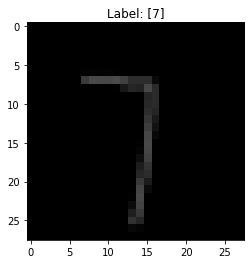

1/1 [==============================] - 0s 16ms/step


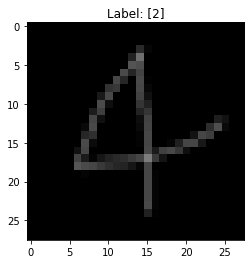

1/1 [==============================] - 0s 15ms/step


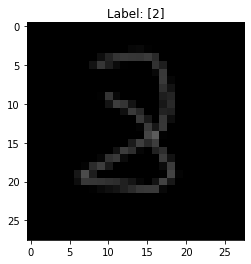

1/1 [==============================] - 0s 17ms/step


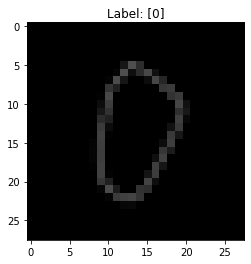

1/1 [==============================] - 0s 13ms/step


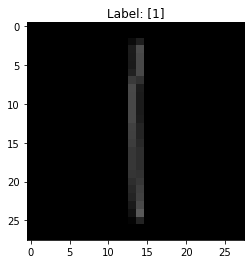

1/1 [==============================] - 0s 14ms/step


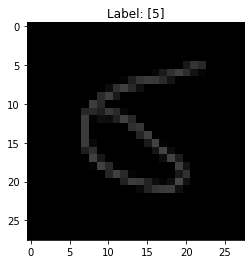

1/1 [==============================] - 0s 14ms/step


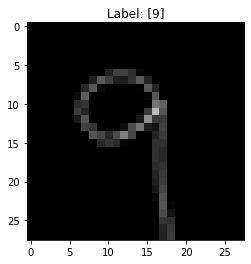

1/1 [==============================] - 0s 13ms/step


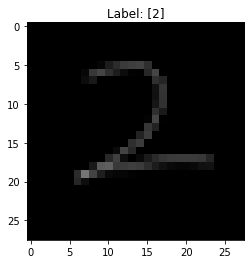

1/1 [==============================] - 0s 14ms/step


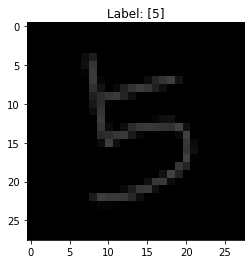

1/1 [==============================] - 0s 13ms/step


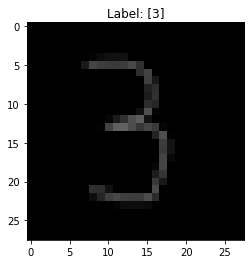

In [23]:
import random
img_paths = ["./手写体/"+str(i)+".png" for i in range(0,10)]
random.shuffle(img_paths)
for img_path in img_paths:
    img = normalize_figure(img_path)
    img_array = np.array(img).reshape(1,28,28,1)/255
    predictions = load_model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    plt.title(f'Label: {predicted_class}')
    plt.imshow(img,cmap='Greys',interpolation='nearest')
    plt.show()

In [24]:
from tensorflow.keras.layers import Dropout
class DNN(Model):
    def __init__(self):
        super(DNN,self).__init__()
        self.d1 = Dense(128,input_shape=(28,28,1),activation='relu')
        self.d4 = Dense(128,activation='relu')
        self.d5 = Dense(10)
    
    def call(self, x, training=False):
        x = self.d1(x)
        x = self.d2(x)
        if training:
            x = self.d3(x, training=training)
        x = self.d4(x)
        x = self.d5(x)
        return x
    
    

In [25]:
model = DNN()

In [26]:
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>


In [27]:
import time
EPOCHS = 10

for epoch in range(EPOCHS):
  # 梯度清空
    start_time = time.time()  # 开始计时
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)


    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    end_time = time.time()  # 结束计时
    epoch_time = end_time - start_time
    
    print(
    f'Epoch {epoch + 1}, '
    f'Time: {epoch_time:.2f} sec, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
    )


Epoch 1, Time: 25.10 sec, Loss: 0.0031515362206846476, Accuracy: 99.88666534423828, Test Loss: 0.08184449374675751, Test Accuracy: 98.50999450683594
Epoch 2, Time: 26.54 sec, Loss: 0.0031247755978256464, Accuracy: 99.89833068847656, Test Loss: 0.08501341193914413, Test Accuracy: 98.5199966430664
Epoch 3, Time: 25.90 sec, Loss: 0.0026776595041155815, Accuracy: 99.9183349609375, Test Loss: 0.09076978266239166, Test Accuracy: 98.33999633789062
Epoch 4, Time: 25.48 sec, Loss: 0.0024919207207858562, Accuracy: 99.91999816894531, Test Loss: 0.10101155191659927, Test Accuracy: 98.4000015258789
Epoch 5, Time: 26.63 sec, Loss: 0.0026129113975912333, Accuracy: 99.91666412353516, Test Loss: 0.10090038925409317, Test Accuracy: 98.25999450683594
Epoch 6, Time: 27.85 sec, Loss: 0.002263057976961136, Accuracy: 99.92832946777344, Test Loss: 0.09761291742324829, Test Accuracy: 98.5199966430664
Epoch 7, Time: 26.65 sec, Loss: 0.001358579145744443, Accuracy: 99.95166778564453, Test Loss: 0.091475516557693

KeyboardInterrupt: 

In [ ]:
import random
img_paths = ["./手写体/"+str(i)+".png" for i in range(0,1)]
for img_path in img_paths:
    img = normalize_figure(img_path)
    img_array = np.array(img).reshape(1,28,28,1)/255
    conv_model = tf.keras.models.Model(inputs=model.input_layer, outputs=model.conv1.output)
    conv_output = conv_model(img_array)
    def visualize_conv_output(conv_output):
        fig, axes = plt.subplots(4, 8, figsize=(15, 8))
        for i, ax in enumerate(axes.flat):
            if i < conv_output.shape[-1]:
                ax.imshow(conv_output[0, :, :, i], cmap='gray')
            ax.axis('off')
        plt.show()

    visualize_conv_output(conv_output.numpy())

In [ ]:
print(model.inputs)

In [ ]:
conv_output = conv_model(img_array)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import svm

# 数据转换为适合SVM格式
x_train_flat = x_train.reshape(-1, 28*28)
x_test_flat = x_test.reshape(-1, 28*28)

# 定义SVM参数搜索范围
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

# 创建SVM模型
svm_model = svm.SVC()

# 使用GridSearchCV进行参数搜索
grid_search = GridSearchCV(svm_model, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(x_train_flat, y_train)

# 打印最佳参数
print("Best parameters found: ", grid_search.best_pams_)

# 打印每种参数组合的结果
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Accuracy: {mean_score:.4f} with params: {params}")

# 使用最佳参数评估测试集
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(x_test_flat)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# 数据转换为适合KNN格式
x_train_flat = x_train.reshape(-1, 28*28)
x_test_flat = x_test.reshape(-1, 28*28)

# 定义KNN参数搜索范围
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# 创建KNN模型
knn_model = KNeighborsClassifier()

# 使用GridSearchCV进行参数搜索
grid_search = GridSearchCV(knn_model, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(x_train_flat, y_train)

# 打印最佳参数
print("Best parameters found: ", grid_search.best_params_)

# 打印每种参数组合的结果
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Accuracy: {mean_score:.4f} with params: {params}")

# 使用最佳参数评估测试集
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(x_test_flat)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

In [28]:
import sklearn
print(sklearn.__version__)

1.4.1.post1


In [29]:
print(np.__version__)

1.26.4


In [30]:
import matplotlib

matplotlib.__version__

'3.5.1'